In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from imutils import paths
import os
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout,Flatten,Dense,Input
from keras import Sequential
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from scipy.constants import lb
import numpy as np
import cv2 as cv
import math
import imutils
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
import pandas as pd


In [3]:
def midpoint(ptA, ptB):
	return (ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5

In [4]:
def matchTemplatePrivate(img):
    METHOD = cv.TM_CCOEFF

    # lê novamente a imagem para evitar dados quebrados
    edged_img = cv.adaptiveThreshold(img, 255,
                                     cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 21, 10)

    img2 = img.copy()

    # carrega template para joelho esquerdo e direito
    template_l = cv.imread("../templates/template_L.png", 0)
    template_r = cv.imread("../templates/template_R.png", 0)

    # encontra contornos
    edged_template_l = cv.adaptiveThreshold(template_r, 255,
                                            cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 21, 10)

    edged_template_r = cv.adaptiveThreshold(template_l, 255,
                                            cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 21, 10)

    w_l, h_l = template_l.shape[::-1]
    w_r, h_r = template_l.shape[::-1]

    # aplica o math template em ambas as imagens de template
    res_l = cv.matchTemplate(edged_img, edged_template_l, METHOD)
    res_r = cv.matchTemplate(edged_img, edged_template_r, METHOD)

    min_val_l, max_val_l, min_loc_l, max_loc_l = cv.minMaxLoc(res_l)
    min_val_r, max_val_r, min_loc_r, max_loc_r = cv.minMaxLoc(res_r)

    # define qual imagem deu melhor match
    if max_val_r > max_val_l:
        top_left = max_loc_r
        bottom_right = (top_left[0] + w_r, top_left[1] + h_r)
    else:
        top_left = max_loc_l
        bottom_right = (top_left[0] + w_l, top_left[1] + h_l)

    return top_left, bottom_right

In [5]:
def processImage(image):
    image = img_to_array(image, dtype='uint8')
    x, y = matchTemplatePrivate(image)
    image = image[x[1]:y[1],x[0]:y[0]]
    image = array_to_img(image)
    image = image.resize((224,224))
    image = img_to_array(image)
    #return cv.cvtColor(image,cv.COLOR_GRAY2RGB)
    return image

In [6]:
def find_distance_between_bones(img):
    gray = cv.GaussianBlur(img, (7, 7), 0)
    # perform edge detection, then perform a dilation + erosion to
    # close gaps in between object edges
    edged = cv.Canny(gray, 50, 100)
    edged = cv.dilate(edged, None, iterations=1)
    edged = cv.erode(edged, None, iterations=1)
    # find contours in the edge map
    cnts = cv.findContours(edged.copy(), cv.RETR_EXTERNAL,
        cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    (cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")
    colors = ((0, 0, 255), (240, 0, 159), (0, 165, 255), (255, 255, 0),
        (255, 0, 255))
    refObj = None
    
    menorDistancia = math.inf
    distancias = 0
    cont = 0
    
    for c in cnts:
        # if the contour is not sufficiently large, ignore it
        #if cv.contourArea(c) < 10:
        #   continue
        # compute the rotated bounding box of the contour
        box = cv.minAreaRect(c)
        box = cv.cv.BoxPoints(box) if imutils.is_cv2() else cv.boxPoints(box)
        box = np.array(box, dtype="int")
        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        box = perspective.order_points(box)
        # compute the center of the bounding box
        cX = np.average(box[:, 0])
        cY = np.average(box[:, 1])
        # if this is the first contour we are examining (i.e.,
        # the left-most contour), we presume this is the
        # reference object
        if refObj is None:
            # unpack the ordered bounding box, then compute the
            # midpoint between the top-left and top-right points,
            # followed by the midpoint between the top-right and
            # bottom-right
            (tl, tr, br, bl) = box
            (tlblX, tlblY) = midpoint(tl, bl)
            (trbrX, trbrY) = midpoint(tr, br)
            # compute the Euclidean distance between the midpoints,
            # then construct the reference object
            D = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
            refObj = (box, (cX, cY), D / 224)
            continue
        # draw the contours on the image
        orig = img.copy()
        cv.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
        cv.drawContours(orig, [refObj[0].astype("int")], -1, (0, 255, 0), 2)
        # stack the reference coordinates and the object coordinates
        # to include the object center
        refCoords = np.vstack([refObj[0], refObj[1]])
        objCoords = np.vstack([box, (cX, cY)])
        # loop over the original points
        for ((xA, yA), (xB, yB), color) in zip(refCoords, objCoords, colors):
            
            # draw circles corresponding to the current points and
            # connect them with a line
            cv.circle(orig, (int(xA), int(yA)), 5, color, -1)
            cv.circle(orig, (int(xB), int(yB)), 5, color, -1)
            cv.line(orig, (int(xA), int(yA)), (int(xB), int(yB)),
                color, 2)
            # compute the Euclidean distance between the coordinates,
            # and then convert the distance in pixels to distance in
            # units
            D = dist.euclidean((xA, yA), (xB, yB)) / refObj[2]

            distancias += D
            cont+=1
            if D< menorDistancia:
                menorDistancia = D

            (mX, mY) = midpoint((xA, yA), (xB, yB))
            cv.putText(orig, "{:.1f}in".format(D), (int(mX), int(mY - 10)),
                cv.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)
            # show the output image
            #cv.imshow("Image", orig)
            #cv.waitKey(0)
    
    if cont == 0:
        mediaDistancia = 0
    else:
        mediaDistancia = (distancias/cont)
        
    if menorDistancia == math.inf:
        menorDistancia = 0
    return mediaDistancia, menorDistancia

In [7]:
def count_black_pixels(image):
    # print(cropped)
    ret, bw = cv.threshold(image, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
    # count non zero
    IMAGE_SIZE = 224 * 224
    response = cv.countNonZero(bw)
    return IMAGE_SIZE - response

In [8]:
def count_binary_pixels(image):
    # print(cropped)
    ret, bw = cv.threshold(image, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
    # count non zero
    IMAGE_SIZE = 224 * 224
    response = cv.countNonZero(bw)
    return (IMAGE_SIZE - response), response

In [9]:
train_dataset = "C:\\Users\\Windows 10\\Documents\\PUC\\2022_2\\PAI\\KneeXrayData\\ClsKLData\\kneeKL224\\train_preprocessed"
val_dataset = "C:\\Users\\Windows 10\\Documents\\PUC\\2022_2\\PAI\\KneeXrayData\\ClsKLData\\kneeKL224\\val_preprocessed"
test_dataset = "C:\\Users\\Windows 10\\Documents\\PUC\\2022_2\\PAI\\KneeXrayData\\ClsKLData\\kneeKL224\\test_preprocessed"

In [10]:
train_images=list(paths.list_images(train_dataset))
val_images=list(paths.list_images(val_dataset))
test_images=list(paths.list_images(test_dataset))

In [11]:
train_data=[]
train_labels=[]
val_data=[]
val_labels=[]
test_data=[]
test_labels=[]

for i in train_images:#adicionar nosso preprocessamento
    label=i.split(os.path.sep)[-2]
    train_labels.append(label)
    image = load_img(i,target_size=(224,224), color_mode="grayscale")
    image = processImage(image)
    train_data.append(image)

for i in val_images:#adicionar nosso preprocessamento
    label=i.split(os.path.sep)[-2]
    val_labels.append(label)
    image = load_img(i,target_size=(224,224), color_mode="grayscale")
    image = processImage(image)
    val_data.append(image)

for i in test_images:#adicionar nosso preprocessamento
    label=i.split(os.path.sep)[-2]
    test_labels.append(label)
    image = load_img(i,target_size=(224,224), color_mode="grayscale")
    image = processImage(image)
    test_data.append(image)

In [12]:
print(test_data[0].shape)
print(len(val_data))
print(len(val_labels))

(224, 224, 1)
1652
1652


In [13]:
train_data=np.array(train_data, dtype='uint8')
train_labels=np.array(train_labels)

val_data=np.array(val_data, dtype='uint8')
val_labels=np.array(val_labels)

test_data=np.array(test_data, dtype='uint8')
test_labels=np.array(test_labels)

In [14]:
train_data[0].shape

(224, 224, 1)

In [15]:
print(find_distance_between_bones(train_data[6346]))

(0, 0)


Usando media e menor distancia entre pontos

In [16]:
train_data_table = []
for data in train_data:
    media, menor = find_distance_between_bones(data)
    train_data_table.append((media,menor))

In [17]:
test_data_table = []
for data in test_data:
    media, menor = find_distance_between_bones(data)
    test_data_table.append((media,menor))

Usando contagem de pontos pretos

In [18]:
train_data_table = []
i = 0
for data in train_data:
    count_black = count_black_pixels(data)
    train_data_table.append((i,count_black))
    i += 1

In [19]:
test_data_table = []
i = 0
for data in test_data:
    count_black = count_black_pixels(data)
    test_data_table.append((i,count_black))
    i += 1

In [20]:
len(train_data_table)

11556

In [21]:
train_data_table

[(0, 22096),
 (1, 22693),
 (2, 23956),
 (3, 24344),
 (4, 19258),
 (5, 19214),
 (6, 17866),
 (7, 17500),
 (8, 24100),
 (9, 24114),
 (10, 26115),
 (11, 24854),
 (12, 26539),
 (13, 26539),
 (14, 25844),
 (15, 26132),
 (16, 26598),
 (17, 26751),
 (18, 26145),
 (19, 26478),
 (20, 26200),
 (21, 26318),
 (22, 22408),
 (23, 21862),
 (24, 24463),
 (25, 24521),
 (26, 24690),
 (27, 24903),
 (28, 25294),
 (29, 25044),
 (30, 21074),
 (31, 21213),
 (32, 21768),
 (33, 21373),
 (34, 23638),
 (35, 22053),
 (36, 22093),
 (37, 22102),
 (38, 22035),
 (39, 22170),
 (40, 23279),
 (41, 23699),
 (42, 20808),
 (43, 20659),
 (44, 17899),
 (45, 18271),
 (46, 23742),
 (47, 23954),
 (48, 28567),
 (49, 28243),
 (50, 26712),
 (51, 27029),
 (52, 22658),
 (53, 22912),
 (54, 22964),
 (55, 23020),
 (56, 22137),
 (57, 22778),
 (58, 23688),
 (59, 23656),
 (60, 21706),
 (61, 21352),
 (62, 22284),
 (63, 22492),
 (64, 22594),
 (65, 23116),
 (66, 22843),
 (67, 22581),
 (68, 23578),
 (69, 24569),
 (70, 25275),
 (71, 23994),
 (

In [22]:
train_labels

array(['0', '0', '0', ..., '4', '4', '4'], dtype='<U1')

In [23]:
type(train_data_table)

list

In [24]:
train_labels

array(['0', '0', '0', ..., '4', '4', '4'], dtype='<U1')

In [25]:
len(train_labels)

11556

In [26]:
clf = SVC(kernel='rbf').fit(train_data_table, train_labels)

In [27]:
clf_predict = clf.predict(test_data_table)

In [28]:
clf_accuracy = accuracy_score(test_labels, clf_predict)

In [29]:
print('Accuracy (RBF Kernel): ', "%.2f" % (clf_accuracy*100))

Accuracy (RBF Kernel):  38.59


In [30]:
train_data_np = np.array(train_data_table, dtype=object)

In [31]:
train_labels = np.array(train_labels, dtype=object)
train_labels_int = train_labels.astype(np.dtype(np.int_))

In [37]:
test_labels = np.array(test_labels, dtype=object)
test_labels_int = test_labels.astype(np.dtype(np.int_))

In [40]:
# instanciar o modelo XGBoost
model = XGBClassifier(n_estimators = 650,
                      max_depth = 10,
                      learning_rate = 0.01,
                      subsample = 1,
                      random_state = 0
                     )
# chamar o fit para o modelo
history = model.fit(train_data_np, train_labels_int, verbose=False)

In [33]:
# fazer previsões em cima do dataset de teste
predictions = model.predict(test_data_table)

In [39]:
pd.DataFrame(data={'Actual': test_labels, 'Predict': predictions})

,Actual,Predict
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
3307,4,0
3308,4,0
3309,4,0
3310,4,0


In [35]:
len(test_data_table)

3312

C:\Users\Windows 10\Documents\PUC\2022_2\PAI\PAI_ArtroseDetection\pai\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


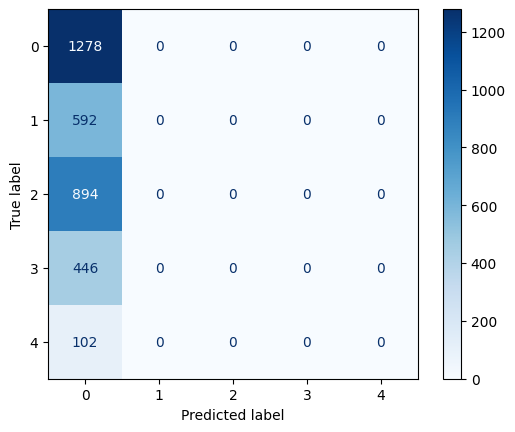

In [38]:
plot_confusion_matrix(model, test_data_table, test_labels_int, cmap='Blues')